# Realizando imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import re
from shapely.geometry import Point, Polygon

# Lendo o mapa de Alagoas e transformando o crs para o crs adequado

In [2]:
mapa = gpd.read_file('Shapefiles/27SEE250GC_SIR.shp')
mapa.crs = {'init': 'epsg:4326'}
mapa = mapa.to_crs({'init': 'epsg:31984'})
mapa.crs

{'init': 'epsg:31984'}

In [3]:
# Localizando Santana do Ipanema
santana = mapa.loc[(mapa['NM_MUNICIP'] == 'SANTANA DO IPANEMA')]

In [4]:
# Localizando a região urbana de Santana do Ipanema
santana_regiao_urbana = santana.loc[(santana['TIPO'] == 'URBANO')]
santana_regiao_urbana = santana_regiao_urbana.drop(columns=['CD_GEOCODB', 
                                                            'NM_BAIRRO', 
                                                            'CD_GEOCODS', 
                                                            'NM_SUBDIST',
                                                            'CD_GEOCODM',
                                                            'NM_MICRO',
                                                            'NM_MESO',
                                                            'CD_GEOCODD', 
                                                            'NM_DISTRIT'])
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry
3251,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,..."
3252,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,..."
3253,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6..."
3254,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,..."
3255,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ..."


# Função para transformar latitude e longitude para o formato de degrees

In [5]:
def dms2dd(s):
    # example: s = """0°51'56.29"S"""
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','O'):
        dd*= -1
    return dd

# Lendo o banco de dados - pacientes (casos)

In [6]:
dados_casos = pd.read_excel('Dados/santana_do_ipanema casos.xlsx')
dados_casos.head()
dados_casos['latitude'] = dados_casos['latitude'].apply(dms2dd)
dados_casos['longitude'] = dados_casos['longitude'].apply(dms2dd)

# Criando a variável com os pontos (Point) de latitude e longitude

In [7]:
geometry= [Point(xy) for xy in zip(dados_casos['longitude'], dados_casos['latitude'])]

# Criando o geodataframe com os dados e plotando o mapa completo de Santana do Ipanema

In [8]:
casos_geodf = gpd.GeoDataFrame(dados_casos, geometry=geometry)
casos_geodf.crs = {'init': 'epsg:4326'}
casos_geodf = casos_geodf.to_crs({'init': 'epsg:31984'})
casos_geodf.head()

,número,latitude,longitude,geometry
0,2010.1,-9.363258,-37.246725,POINT (692542.0010366363 8964507.198203055)
1,2010.2,-9.364133,-37.245350,POINT (692692.5640686504 8964409.662920143)
2,2010.3,-9.360600,-37.247747,POINT (692431.1720079128 8964801.792154483)
3,2010.4,-9.362644,-37.250492,POINT (692128.5660930406 8964577.157985518)
4,2010.5,-9.364867,-37.246592,POINT (692555.7617842549 8964329.229416063)


# Plot do mapa com os casos

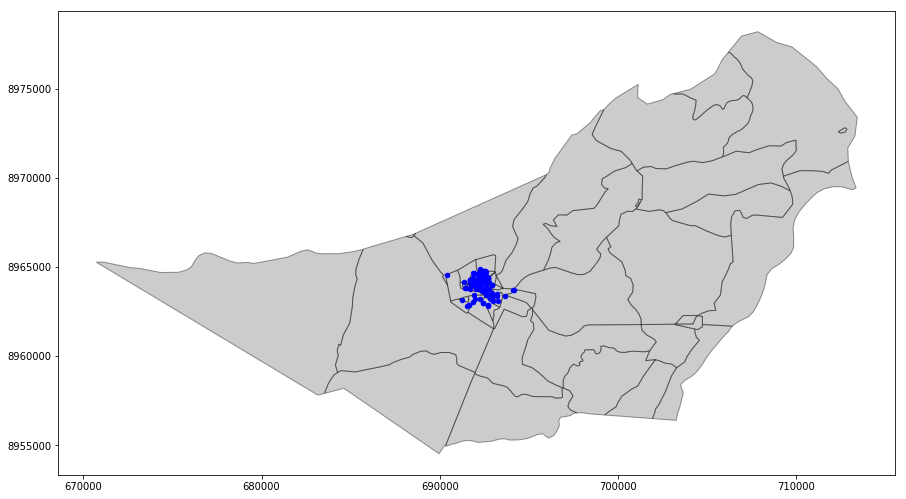

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
santana.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
casos_geodf.plot(ax=ax, markersize=20, color='blue', marker='o', label='Caso')

# Plot dos casos somente na região urbana

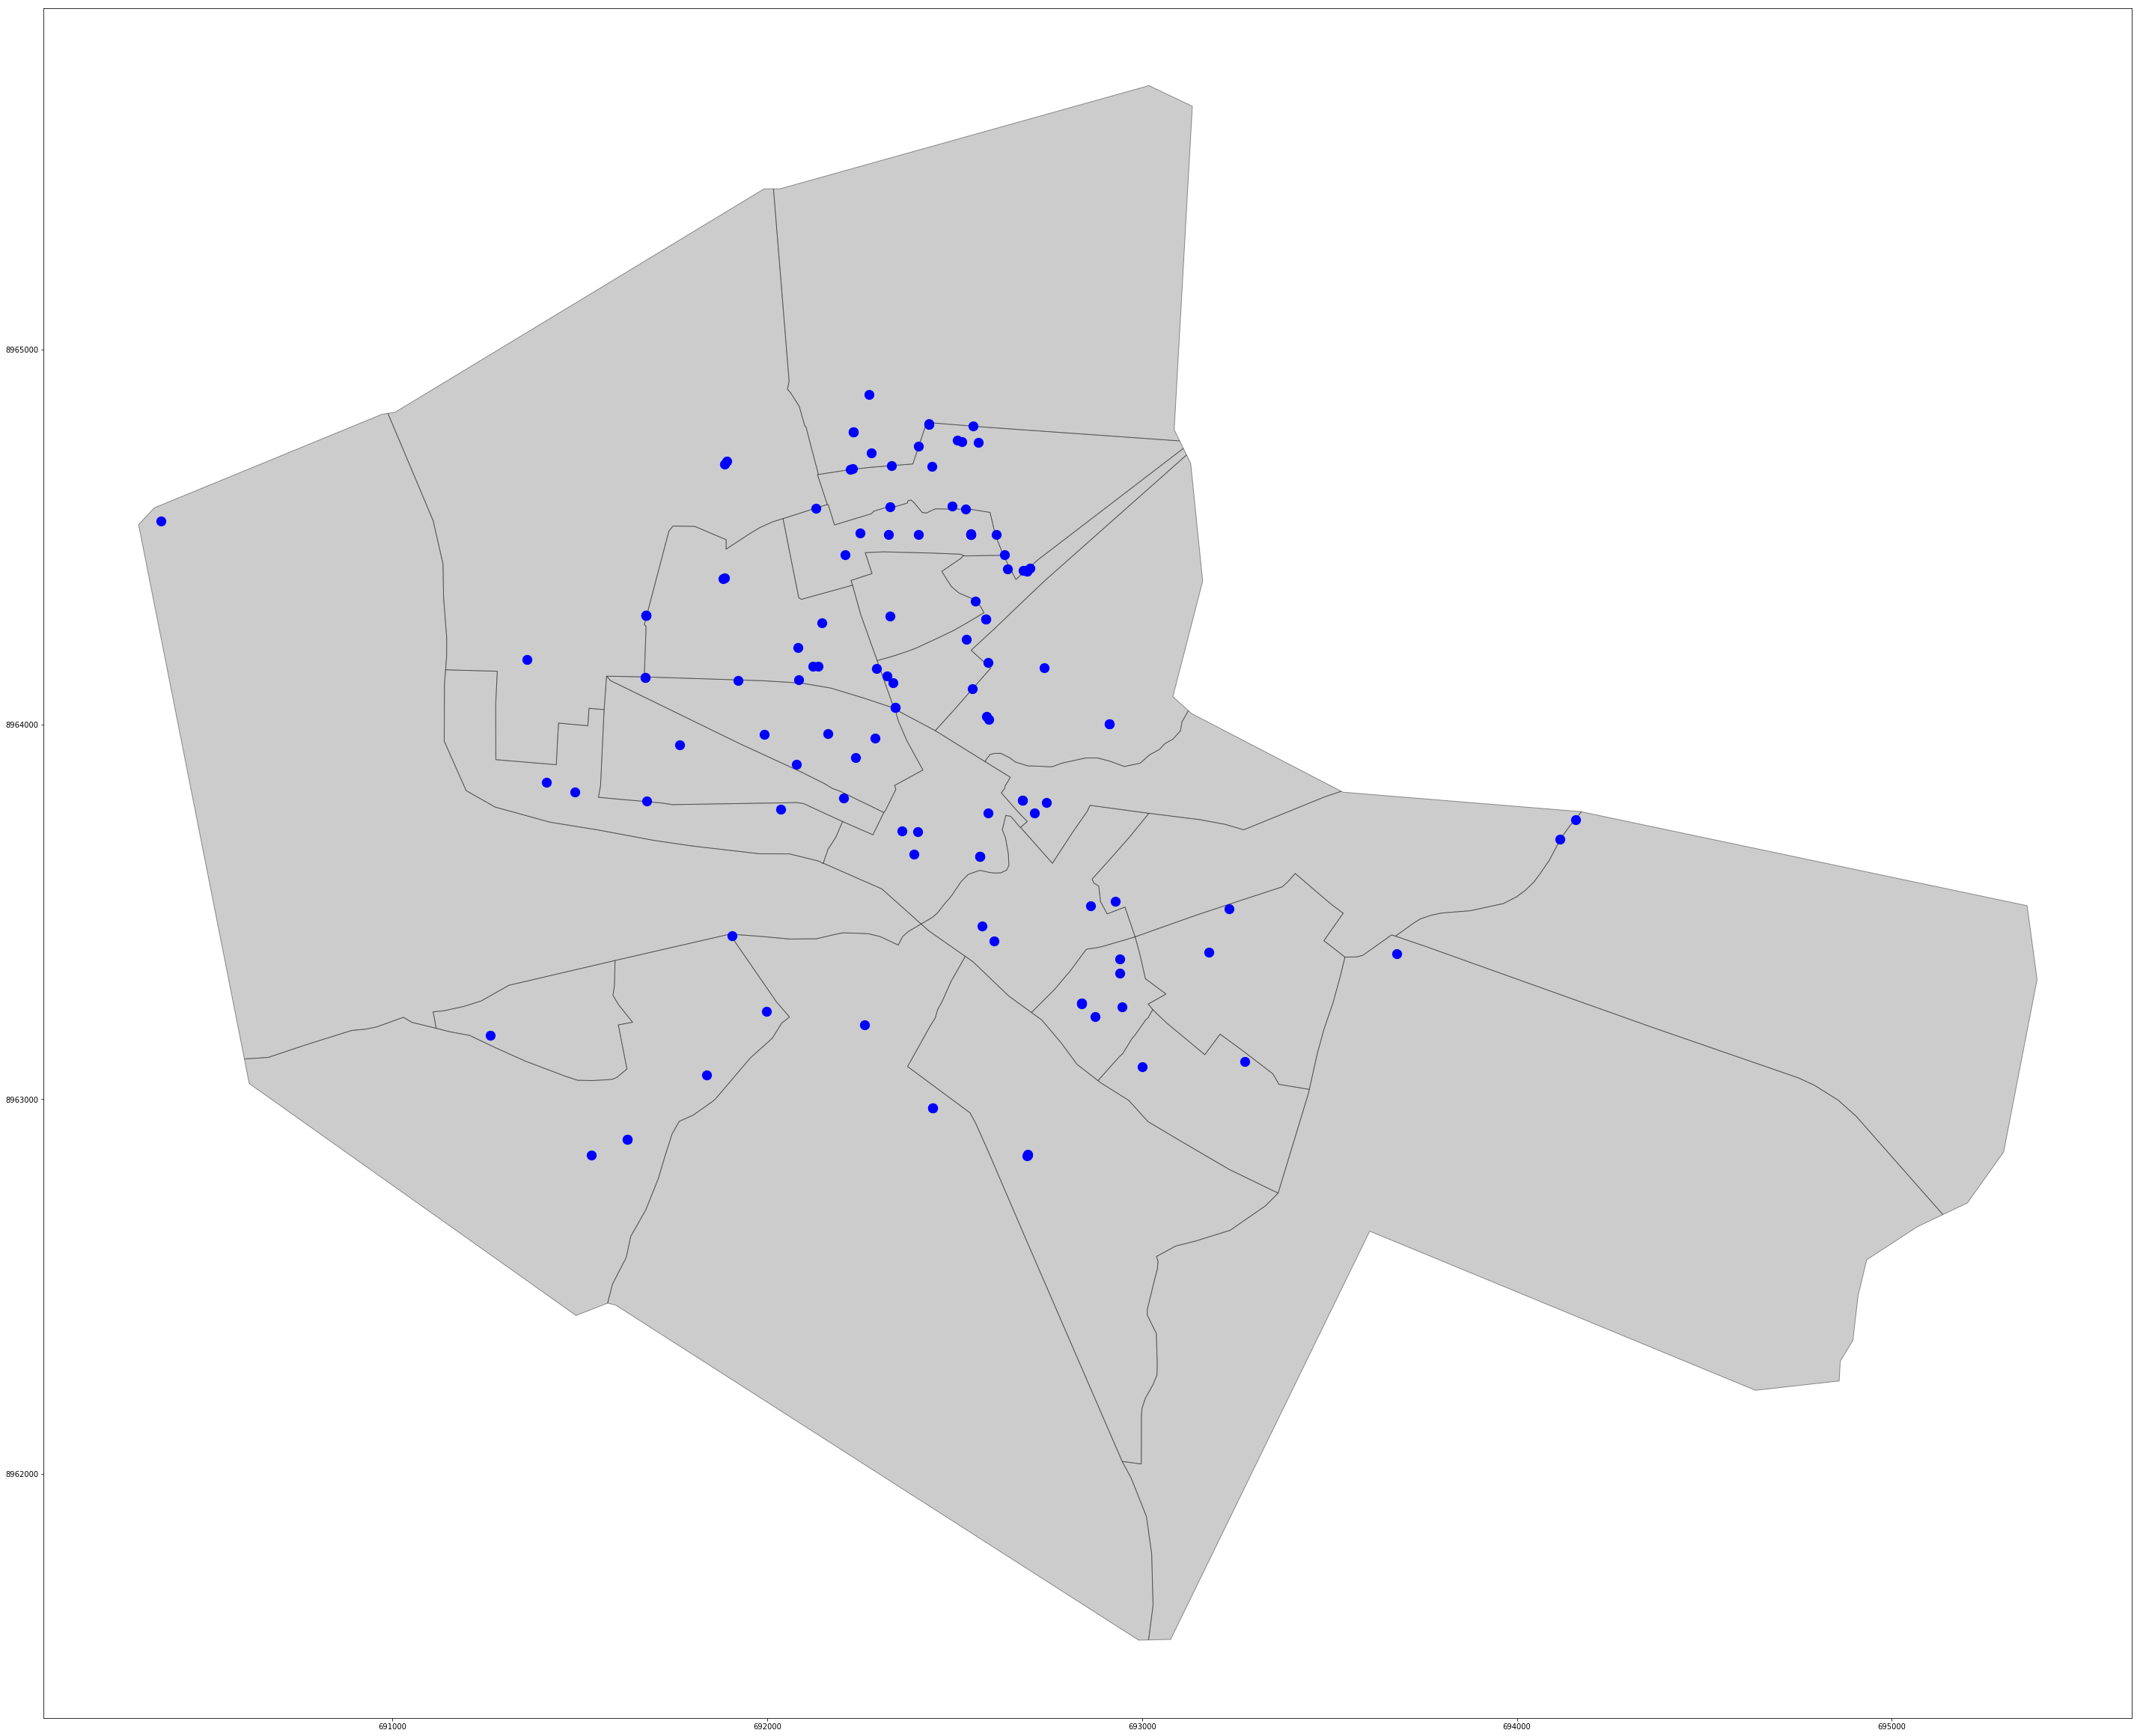

In [10]:
fig, ax = plt.subplots(figsize=(50,50))
santana_regiao_urbana.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
casos_geodf.plot(ax=ax, markersize=150, color='blue', marker='o', label='Caso')

# Laço para inserir no geodataframe dos dados a região censitária na qual o caso está presente

In [11]:
for i, row in casos_geodf.iterrows():
    for f, row2 in santana_regiao_urbana.iterrows():
        if row['geometry'].within(row2['geometry']):
            casos_geodf.at[i, 'CD_GEOCODI'] = santana_regiao_urbana.at[f, 'CD_GEOCODI']
casos_geodf.head()

,número,latitude,longitude,geometry,CD_GEOCODI
0,2010.1,-9.363258,-37.246725,POINT (692542.0010366363 8964507.198203055),270800605000022
1,2010.2,-9.364133,-37.245350,POINT (692692.5640686504 8964409.662920143),270800605000019
2,2010.3,-9.360600,-37.247747,POINT (692431.1720079128 8964801.792154483),270800605000016
3,2010.4,-9.362644,-37.250492,POINT (692128.5660930406 8964577.157985518),270800605000015
4,2010.5,-9.364867,-37.246592,POINT (692555.7617842549 8964329.229416063),270800605000017


In [12]:
# Pequeno dataframe transitório com a quantidade de casos por região censitária
df = pd.DataFrame(casos_geodf['CD_GEOCODI'].value_counts())
df.head()

,CD_GEOCODI
270800605000019,13
270800605000016,13
270800605000021,9
270800605000022,9
270800605000015,9


In [13]:
# Inserindo a quantidade de casos por região no banco de dados dos mapas das regiões censitárias
for i, row in santana_regiao_urbana.iterrows():
    for j, borough in df.iterrows():
        if float(row['CD_GEOCODI']) == float(j):
            santana_regiao_urbana.at[i, 'Casos'] = df.at[j, 'CD_GEOCODI']
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos
3251,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0
3252,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0
3253,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0
3254,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0
3255,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0


# Plot do mapa estilo choropleth com a quantidade de casos por região censitária

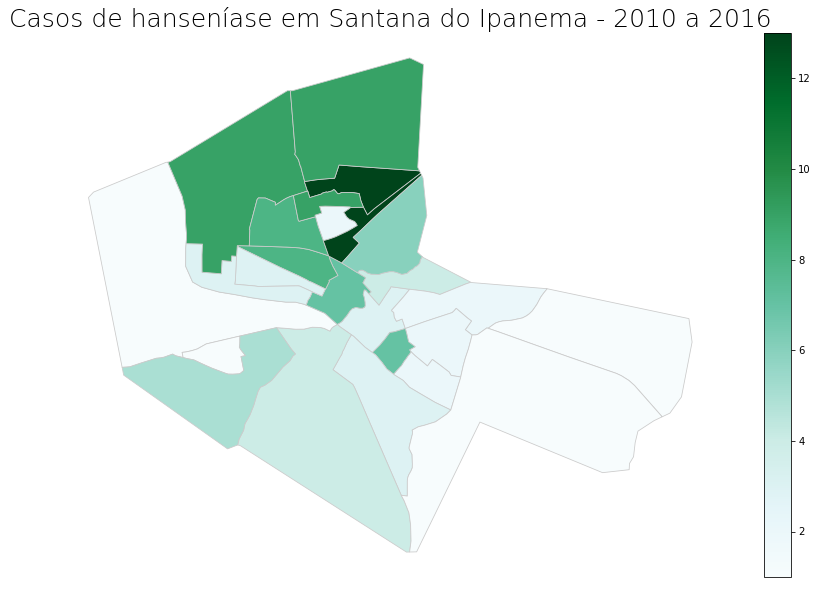

In [14]:
vmin_casos, vmax_casos = santana_regiao_urbana['Casos'].min(), santana_regiao_urbana['Casos'].max()
variable = 'Casos'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos de hanseníase em Santana do Ipanema - 2010 a 2016', fontdict={'fontsize': '25', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos, vmax=vmax_casos))
sm._A = []
cbar = fig.colorbar(sm)
#fig.savefig('santana_do_ipanema.png', dpi=300)

# Mapeamento da cidade por densidade populacional

In [15]:
# Leitura dos dados
densidade_populacional = pd.read_excel('Dados/Base.xls')
densidade_populacional = densidade_populacional.loc[(densidade_populacional['Nome_do_distrito'] == 'SANTANA DO IPANEMA')]
densidade_populacional.head()

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154
3187,270800605000001,2,Região Nordeste,27,Alagoas,2701,Sertão Alagoano,27003,Santana do Ipanema,0,...,18,9,15,9,9,3,1,6,2,0
3188,270800605000002,2,Região Nordeste,27,Alagoas,2701,Sertão Alagoano,27003,Santana do Ipanema,0,...,16,12,19,12,6,3,0,1,3,1
3189,270800605000003,2,Região Nordeste,27,Alagoas,2701,Sertão Alagoano,27003,Santana do Ipanema,0,...,24,15,15,13,9,10,7,4,1,0
3190,270800605000004,2,Região Nordeste,27,Alagoas,2701,Sertão Alagoano,27003,Santana do Ipanema,0,...,12,8,6,10,7,2,2,1,1,0
3191,270800605000005,2,Região Nordeste,27,Alagoas,2701,Sertão Alagoano,27003,Santana do Ipanema,0,...,44,39,16,21,14,12,6,0,0,0


In [16]:
# Obtendo população por setor censitário, onde Cod_setor é o mesmo que CD_GEOCODI no mapa anterior 
# e V014 é o valor da população por setor censitário
densidade_populacional = densidade_populacional[['Cod_setor', 'V014']]
densidade_populacional.head()
densidade_populacional.dtypes

Cod_setor    int64
V014         int64
dtype: object

In [17]:
densidade_populacional = densidade_populacional.rename(index=str, columns={'Cod_setor': 'CD_GEOCODI'})
densidade_populacional.head()

,CD_GEOCODI,V014
3187,270800605000001,695
3188,270800605000002,1043
3189,270800605000003,947
3190,270800605000004,872
3191,270800605000005,1122


In [18]:
santana_regiao_urbana['CD_GEOCODI'] = santana_regiao_urbana['CD_GEOCODI'].apply(pd.to_numeric)
santana_regiao_urbana.dtypes

ID              int64
CD_GEOCODI      int64
TIPO           object
NM_MUNICIP     object
geometry       object
Casos         float64
dtype: object

In [19]:
santana_regiao_urbana = pd.merge(santana_regiao_urbana, densidade_populacional, on='CD_GEOCODI')

In [20]:
santana_regiao_urbana = santana_regiao_urbana.rename(index=str, columns={'V014': 'Populacao'})

In [21]:
# GeoDataFrame com os dados de população adicionados
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos,Populacao
0,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0,695
1,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0,1043
2,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0,947
3,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0,872
4,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0,1122


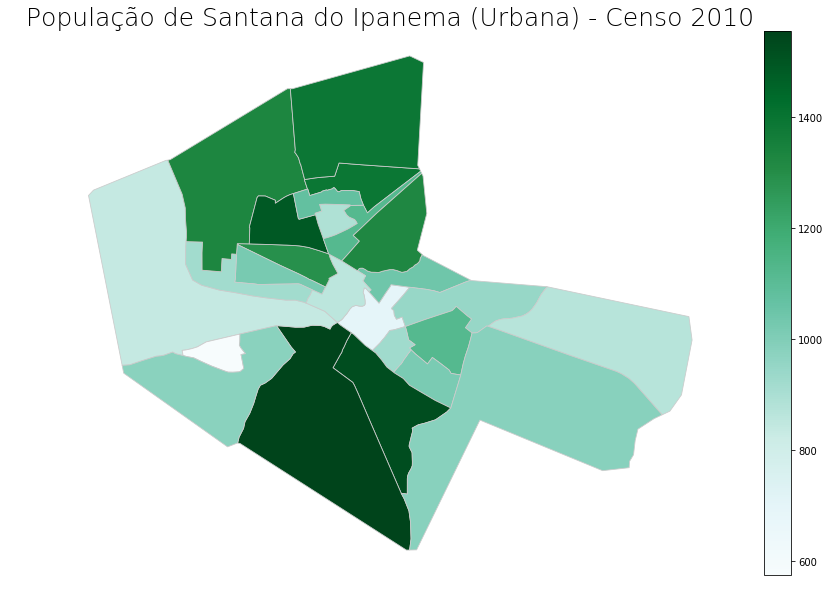

In [22]:
vmin_pop, vmax_pop = santana_regiao_urbana['Populacao'].min(), santana_regiao_urbana['Populacao'].max()
variable_pop = 'Populacao'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('População de Santana do Ipanema (Urbana) - Censo 2010', fontdict={'fontsize': '25', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_pop, vmax=vmax_pop))
sm._A = []
cbar = fig.colorbar(sm)
fig.savefig('População Santana do Ipanema.png', dpi=300)

# Adicionando a coluna 'Área', em km², ao GeoDF dos dados

In [23]:
santana_regiao_urbana['Area km²'] = (santana_regiao_urbana['geometry'].area)/1000000

In [24]:
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos,Populacao,Area km²
0,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0,695,0.159650
1,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0,1043,0.154458
2,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0,947,0.328950
3,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0,872,0.852885
4,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0,1122,0.197749


In [25]:
santana_regiao_urbana['Densidade populacional'] = santana_regiao_urbana['Populacao']/santana_regiao_urbana['Area km²']
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos,Populacao,Area km²,Densidade populacional
0,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0,695,0.159650,4353.279696
1,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0,1043,0.154458,6752.662334
2,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0,947,0.328950,2878.855381
3,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0,872,0.852885,1022.411650
4,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0,1122,0.197749,5673.854867


# Plotando o mapa da densidade populacional região urbana

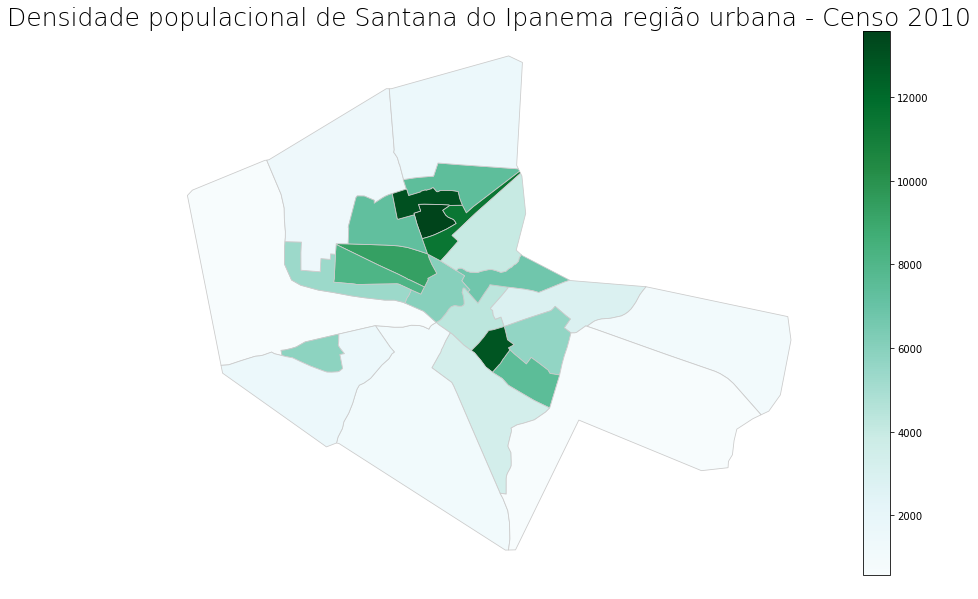

In [26]:
vmin_dens, vmax_dens = santana_regiao_urbana['Densidade populacional'].min(), santana_regiao_urbana['Densidade populacional'].max()
variable_pop = 'Densidade populacional'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Densidade populacional de Santana do Ipanema região urbana - Censo 2010', fontdict={'fontsize': '25', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_dens, vmax=vmax_dens))
sm._A = []
cbar = fig.colorbar(sm)
fig.savefig('Densidade populacional Santana do Ipanema.png', dpi=300)

In [27]:
santana_regiao_urbana['Casos/Densidade pop x 10000'] = (santana_regiao_urbana['Casos']/santana_regiao_urbana['Densidade populacional'])*10000
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos,Populacao,Area km²,Densidade populacional,Casos/Densidade pop x 10000
0,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0,695,0.159650,4353.279696,6.891356
1,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0,1043,0.154458,6752.662334,5.923590
2,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0,947,0.328950,2878.855381,6.947206
3,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0,872,0.852885,1022.411650,9.780796
4,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0,1122,0.197749,5673.854867,3.524940


# Plotando o mapa dos casos divididos pela densidade populacional x 10000 (normalizado)

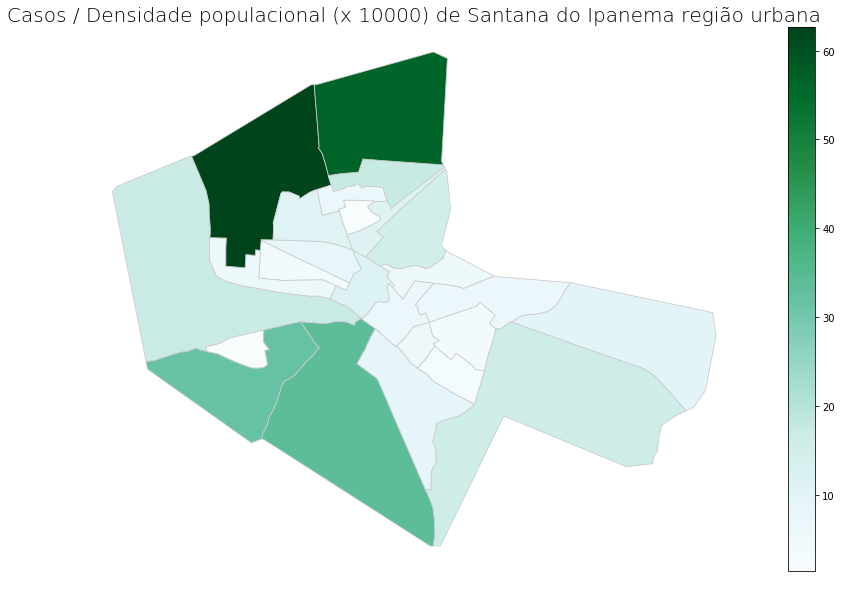

In [28]:
vmin_casos_dens, vmax_casos_dens = santana_regiao_urbana['Casos/Densidade pop x 10000'].min(), santana_regiao_urbana['Casos/Densidade pop x 10000'].max()
variable_pop = 'Casos/Densidade pop x 10000'
fig, ax = plt.subplots(1, figsize=(15, 10))
#ax.legend(title='Legend')
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Densidade populacional (x 10000) de Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_dens, vmax=vmax_casos_dens))
sm._A = []
cbar = fig.colorbar(sm)
fig.savefig('Casos por Densidade populacional Santana do Ipanema x 10000.png', dpi=300)

# Plotando o mapa dos casos divididos pela área (km²) 

In [29]:
santana_regiao_urbana['Casos/Área km²'] = round((santana_regiao_urbana['Casos']/santana_regiao_urbana['Area km²']), 2)
santana_regiao_urbana.head()

,ID,CD_GEOCODI,TIPO,NM_MUNICIP,geometry,Casos,Populacao,Area km²,Densidade populacional,Casos/Densidade pop x 10000,Casos/Área km²
0,3224,270800605000001,URBANO,SANTANA DO IPANEMA,"POLYGON ((692675.6437840725 8963725.283953169,...",3.0,695,0.159650,4353.279696,6.891356,18.79
1,3225,270800605000002,URBANO,SANTANA DO IPANEMA,"POLYGON ((693123.4208855663 8964036.638797246,...",4.0,1043,0.154458,6752.662334,5.923590,25.90
2,3226,270800605000003,URBANO,SANTANA DO IPANEMA,"POLYGON ((693531.3927750748 8963821.4619256, 6...",2.0,947,0.328950,2878.855381,6.947206,6.08
3,3227,270800605000004,URBANO,SANTANA DO IPANEMA,"POLYGON ((694172.1732712055 8963766.825083245,...",1.0,872,0.852885,1022.411650,9.780796,1.17
4,3228,270800605000005,URBANO,SANTANA DO IPANEMA,"POLYGON ((692981.4133561484 8963432.97937504, ...",2.0,1122,0.197749,5673.854867,3.524940,10.11


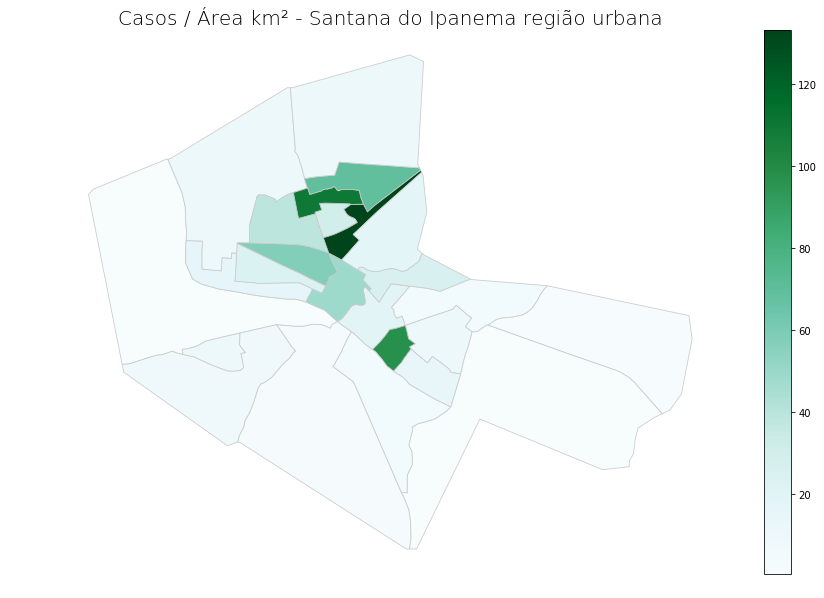

In [30]:
def plota_mapa_casos_area():
    vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
    variable_pop = 'Casos/Área km²'
    fig, ax = plt.subplots(1, figsize=(15, 10))
    #ax.legend(title='Legend')
    santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.axis('off')
    ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
    sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
    sm._A = []
    cbar = fig.colorbar(sm)
    #fig.savefig('Casos por área.png', dpi=300)
plota_mapa_casos_area()

# Adicionado a coluna 'coords' a cada região censitária para definir um ponto em cada área para ilustrar mais os mapas

In [31]:
santana_regiao_urbana['coords'] = santana_regiao_urbana['geometry'].apply(lambda x: x.representative_point().coords[:])
santana_regiao_urbana['coords'] = [coords[0] for coords in santana_regiao_urbana['coords']]

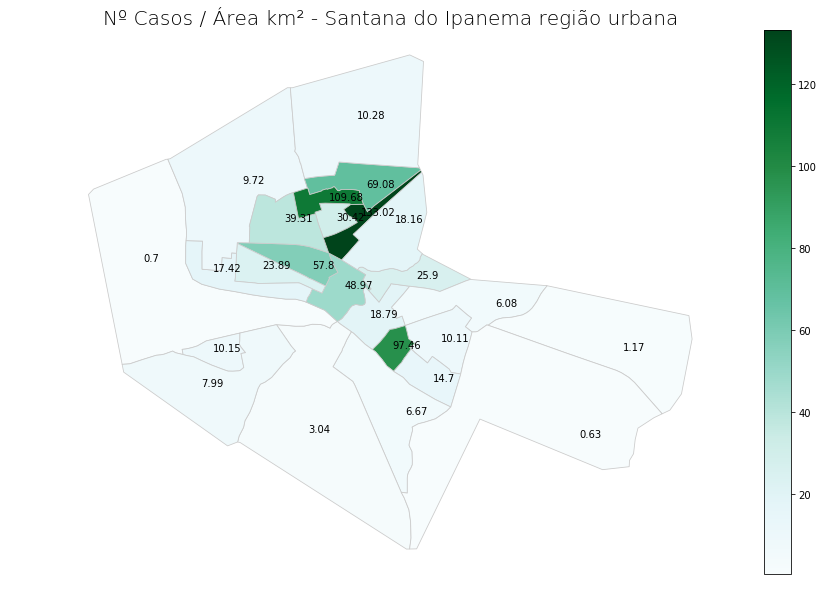

In [32]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Nº Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)
fig.savefig('Número de casos por área.png', dpi=300)
for index, row in santana_regiao_urbana.iterrows():
    plt.annotate(s=row['Casos/Área km²'], xy=row['coords'])

# Abrindo e limpando por dados de localização a base de dados dos contatos

In [33]:
dados_contatos = pd.read_excel('Dados/Contatos.xls')
dados_contatos = dados_contatos[dados_contatos['Latitude'] != 'SEM COORDENADAS']
dados_contatos = dados_contatos.dropna(subset=['Latitude', 'Longitude'])
dados_contatos.head()

,Unnamed: 0,Unnamed: 1,ID,POPULAÇÃO ESTUDADA,NOME COMPLETO,IDADE ENTRADA PROJETO,DT NASC,SEXO,PARENTESCO,FREQ DE CONTATO,...,5.3 SORO IgA,5.4 SALIVA IgM,5.5 SALIVA IgA,6.1 SORO IgM,6.2 SORO IgG,6.3 SORO IgA,6.4 SALIVA IgM,6.5 SALIVA IgA,Latitude,Longitude
0,NaN,1,SI_089/2014,1-CASO,TÂNIA LÚCIA ALVES FRANÇA,45.0,1968-10-23 00:00:00,2-F,NaN,NaN,...,ÑC,ÑC,ÑC,1.28,1.29,0.42,NaN,NaN,9°22'35.06'',37°14'52.44''
1,NaN,2,SI_001/2014,2-CONTATO,HELLYZAMA RADHIJA SILVA FRANÇA,13.0,2001-10-15 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.48,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,9°21'47.86'',37°14'47.10''
2,NaN,3,SI_002/2014,2-CONTATO,GENYSSON WATSON SILVA FRANÇA,8.0,2005-05-28 00:00:00,1-M,SOBRINHO(A),DIÁRIA,...,0.68,0,0.06,ÑC,ÑC,ÑC,ÑC,ÑC,9°21'47.86'',37°14'47.10''
3,NaN,4,SI_003/2014,2-CONTATO,SÂMELA KEYTT SILVA FRANÇA,10.0,2003-09-26 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.34,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,9°21'47.86'',37°14'47.10''
4,NaN,5,SI_088/2014,2-CONTATO,HELIEL ABNER FRANÇA SILVA,13.0,2000-05-22 00:00:00,1-M,FILHO(A),DIÁRIA,...,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,9°22'35.06'',37°14'52.44''


In [34]:
dados_contatos.dtypes

Unnamed: 0                 float64
Unnamed: 1                  object
ID                          object
POPULAÇÃO ESTUDADA          object
NOME COMPLETO               object
IDADE ENTRADA PROJETO      float64
DT NASC                     object
SEXO                        object
PARENTESCO                  object
FREQ DE CONTATO             object
4.1 SORO IgM                object
4.2 SORO IgG                object
4.3 SORO IgA                object
4.4 SALIVA IgM              object
4.5 SALIVA IgA              object
4.6 SALIVA recoleta IgM     object
4.7 SALIVA recoleta IgA     object
5.1 SORO IgM                object
5.2 SORO IgG                object
5.3 SORO IgA                object
5.4 SALIVA IgM              object
5.5 SALIVA IgA              object
6.1 SORO IgM                object
6.2 SORO IgG                object
6.3 SORO IgA                object
6.4 SALIVA IgM              object
6.5 SALIVA IgA              object
Latitude                    object
Longitude           

In [35]:
dados_contatos['Latitude'] = dados_contatos['Latitude'].apply(dms2dd)
dados_contatos['Longitude'] = dados_contatos['Longitude'].apply(dms2dd)
dados_contatos.head()

,Unnamed: 0,Unnamed: 1,ID,POPULAÇÃO ESTUDADA,NOME COMPLETO,IDADE ENTRADA PROJETO,DT NASC,SEXO,PARENTESCO,FREQ DE CONTATO,...,5.3 SORO IgA,5.4 SALIVA IgM,5.5 SALIVA IgA,6.1 SORO IgM,6.2 SORO IgG,6.3 SORO IgA,6.4 SALIVA IgM,6.5 SALIVA IgA,Latitude,Longitude
0,NaN,1,SI_089/2014,1-CASO,TÂNIA LÚCIA ALVES FRANÇA,45.0,1968-10-23 00:00:00,2-F,NaN,NaN,...,ÑC,ÑC,ÑC,1.28,1.29,0.42,NaN,NaN,9.376406,37.247900
1,NaN,2,SI_001/2014,2-CONTATO,HELLYZAMA RADHIJA SILVA FRANÇA,13.0,2001-10-15 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.48,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,9.363294,37.246417
2,NaN,3,SI_002/2014,2-CONTATO,GENYSSON WATSON SILVA FRANÇA,8.0,2005-05-28 00:00:00,1-M,SOBRINHO(A),DIÁRIA,...,0.68,0,0.06,ÑC,ÑC,ÑC,ÑC,ÑC,9.363294,37.246417
3,NaN,4,SI_003/2014,2-CONTATO,SÂMELA KEYTT SILVA FRANÇA,10.0,2003-09-26 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.34,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,9.363294,37.246417
4,NaN,5,SI_088/2014,2-CONTATO,HELIEL ABNER FRANÇA SILVA,13.0,2000-05-22 00:00:00,1-M,FILHO(A),DIÁRIA,...,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,9.376406,37.247900


In [36]:
dados_contatos['Latitude'] *= -1
dados_contatos['Longitude'] *= -1
dados_contatos.head()

,Unnamed: 0,Unnamed: 1,ID,POPULAÇÃO ESTUDADA,NOME COMPLETO,IDADE ENTRADA PROJETO,DT NASC,SEXO,PARENTESCO,FREQ DE CONTATO,...,5.3 SORO IgA,5.4 SALIVA IgM,5.5 SALIVA IgA,6.1 SORO IgM,6.2 SORO IgG,6.3 SORO IgA,6.4 SALIVA IgM,6.5 SALIVA IgA,Latitude,Longitude
0,NaN,1,SI_089/2014,1-CASO,TÂNIA LÚCIA ALVES FRANÇA,45.0,1968-10-23 00:00:00,2-F,NaN,NaN,...,ÑC,ÑC,ÑC,1.28,1.29,0.42,NaN,NaN,-9.376406,-37.247900
1,NaN,2,SI_001/2014,2-CONTATO,HELLYZAMA RADHIJA SILVA FRANÇA,13.0,2001-10-15 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.48,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,-9.363294,-37.246417
2,NaN,3,SI_002/2014,2-CONTATO,GENYSSON WATSON SILVA FRANÇA,8.0,2005-05-28 00:00:00,1-M,SOBRINHO(A),DIÁRIA,...,0.68,0,0.06,ÑC,ÑC,ÑC,ÑC,ÑC,-9.363294,-37.246417
3,NaN,4,SI_003/2014,2-CONTATO,SÂMELA KEYTT SILVA FRANÇA,10.0,2003-09-26 00:00:00,2-F,SOBRINHO(A),DIÁRIA,...,1.34,0.01,0.1,ÑC,ÑC,ÑC,ÑC,ÑC,-9.363294,-37.246417
4,NaN,5,SI_088/2014,2-CONTATO,HELIEL ABNER FRANÇA SILVA,13.0,2000-05-22 00:00:00,1-M,FILHO(A),DIÁRIA,...,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,ÑC,-9.376406,-37.247900


In [37]:
geometry = [Point(xy) for xy in zip(dados_contatos['Longitude'], dados_contatos['Latitude'])]

In [38]:
contatos_geodf = gpd.GeoDataFrame(dados_contatos, geometry=geometry)
contatos_geodf.crs = {'init': 'epsg:4326'}
contatos_geodf = contatos_geodf.to_crs({'init': 'epsg:31984'})
contatos_geodf.crs

{'init': 'epsg:31984'}

# Estratificando a base de dados entre casos e contatos

In [39]:
contatos_coluna_casos = contatos_geodf.loc[(contatos_geodf['POPULAÇÃO ESTUDADA'] == '1-CASO')]
contatos_coluna_contatos = contatos_geodf.loc[(contatos_geodf['POPULAÇÃO ESTUDADA'] == '2-CONTATO')]

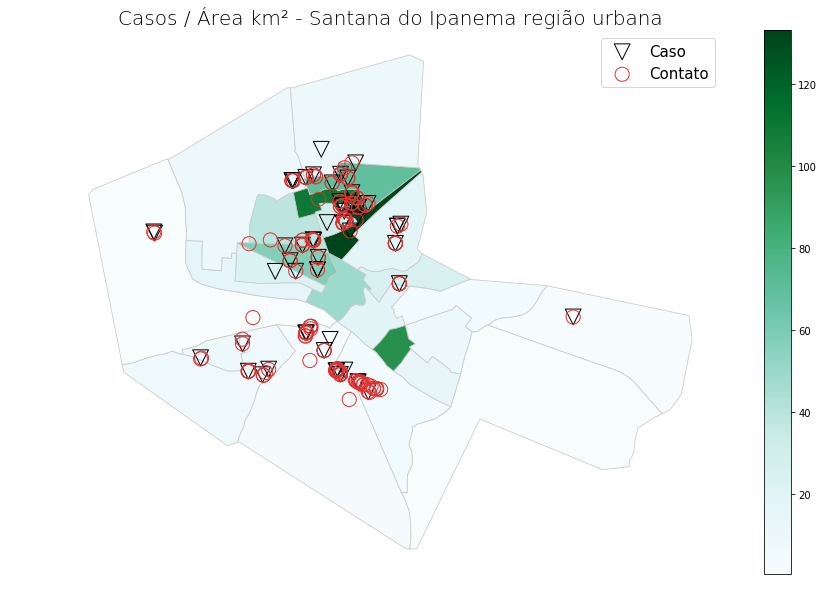

In [40]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

contatos_coluna_casos.plot(ax=ax, markersize=250, edgecolor='black', 
                           marker='v', label='Caso', facecolor='none', 
                           linewidth=1)
contatos_coluna_contatos.plot(ax=ax, markersize=200, edgecolor='#E33131', 
                              marker='o', label='Contato', facecolor='none', 
                              linewidth=1)
leg = ax.legend(fontsize=15)
fig.savefig('Casos e contatos Santana do Ipanema.png', dpi=300)


In [41]:
amostra = '4.1 SORO IgM'
ano1_igm = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano1_igm.dropna(subset=[amostra]) 
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_igm_casos = ano1_igm[ano1_igm['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano1_igm_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano1_igm_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano1_igm_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano1_igm_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

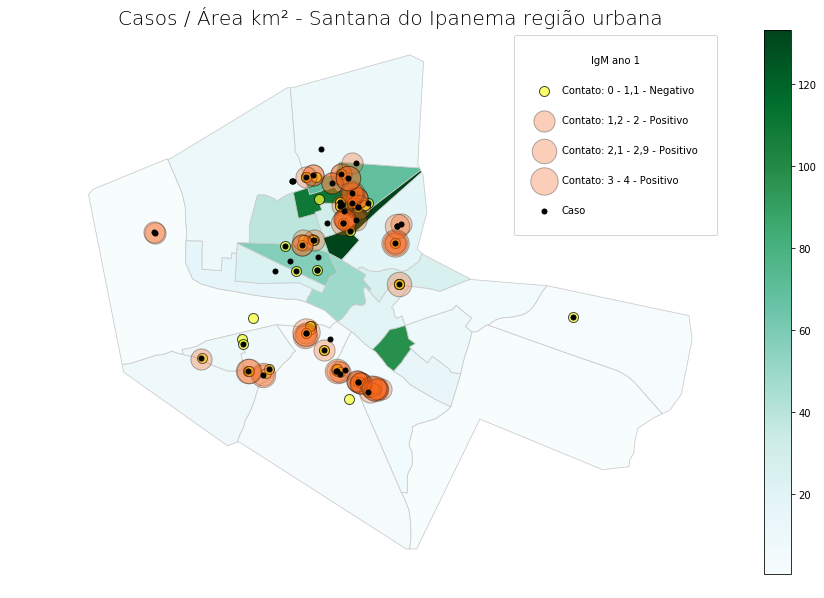

In [42]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_igm_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.7)

ano1_igm_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_igm_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM Ano 1.png', dpi=300)

In [43]:
amostra = '4.2 SORO IgG'
ano1_igg = contatos_geodf[['POPULAÇÃO ESTUDADA', '4.2 SORO IgG', 'geometry']]
coletados = ano1_igg.dropna(subset=['4.2 SORO IgG'])
coletados = coletados[coletados['4.2 SORO IgG'] != 'ÑC']

ano1_igg_casos = ano1_igg[ano1_igg['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano1_igg_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados['4.2 SORO IgG'] < 1.2)
]

ano1_igg_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados['4.2 SORO IgG'] >= 1.2) 
    & (coletados['4.2 SORO IgG'] < 2.1)
]

ano1_igg_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados['4.2 SORO IgG'] >= 2.1) 
    & (coletados['4.2 SORO IgG'] < 3)
]

ano1_igg_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados['4.2 SORO IgG'] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


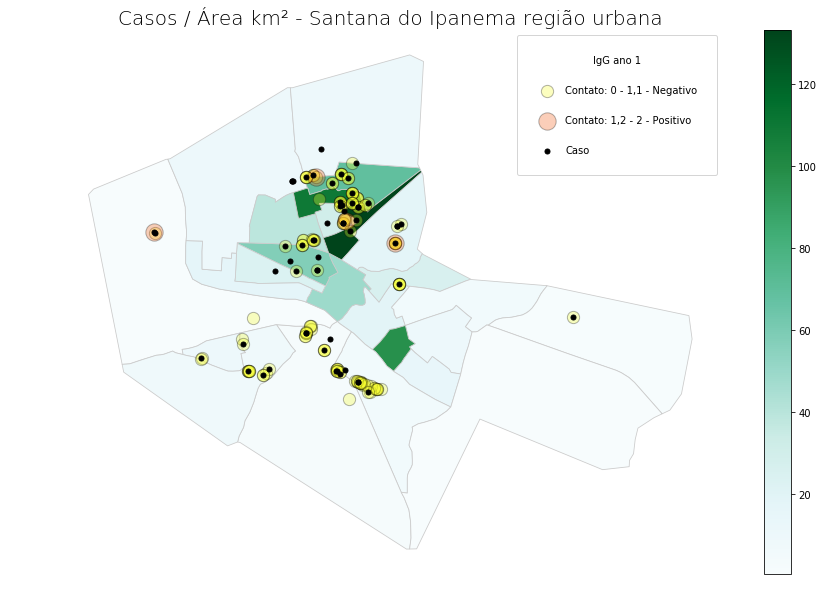

In [44]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_igg_ate_cutoff_contatos.plot(ax=ax, markersize=150, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano1_igg_acima12_abaixo21_contatos.plot(ax=ax, markersize=300, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igg_acima21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igg_acima3_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_igg_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgG ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgG Ano 1.png', dpi=300)

In [45]:
amostra = '4.3 SORO IgA'
ano1_iga = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano1_iga.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_iga_casos = ano1_iga[ano1_iga['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano1_iga_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano1_iga_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano1_iga_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano1_iga_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


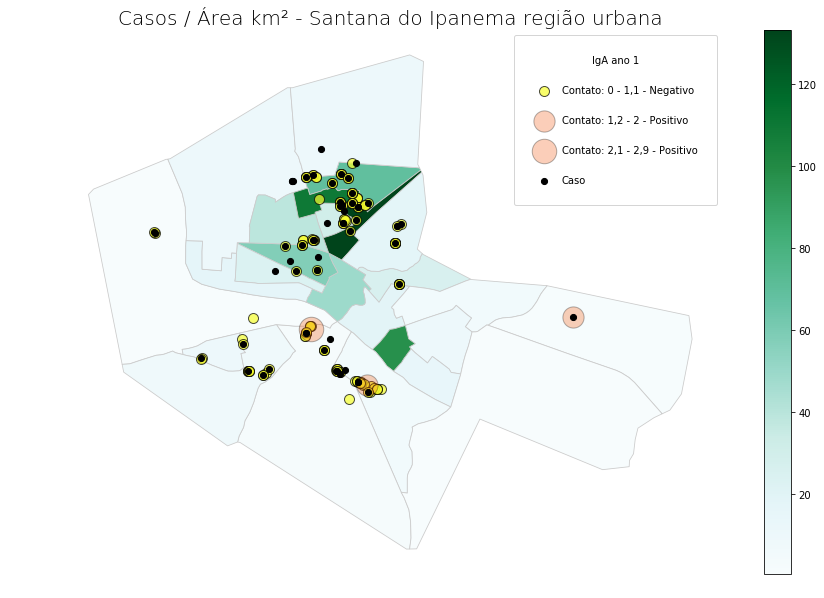

In [46]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_iga_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.7)

ano1_iga_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_iga_casos.plot(ax=ax, markersize=150, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgA ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA Ano 1.png', dpi=300)

In [47]:
amostra = '5.1 SORO IgM'
ano2_igm = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano2_igm.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano2_igm_casos = ano2_igm[ano2_igm['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano2_igm_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados['5.1 SORO IgM'] < 1.2)
]

ano2_igm_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano2_igm_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano2_igm_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

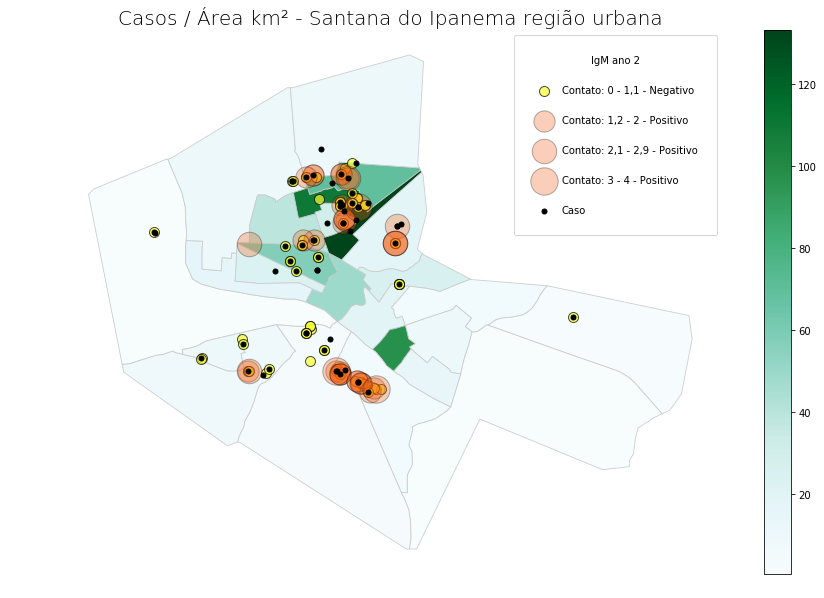

In [48]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano2_igm_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.7)

ano2_igm_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igm_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igm_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano2_igm_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM ano 2', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM Ano 2.png', dpi=300)

In [49]:
amostra = '5.2 SORO IgG'
ano2_igg = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano2_igg.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano2_igg_casos = ano2_igg[ano2_igg['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano2_igg_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano2_igg_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano2_igg_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano2_igg_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


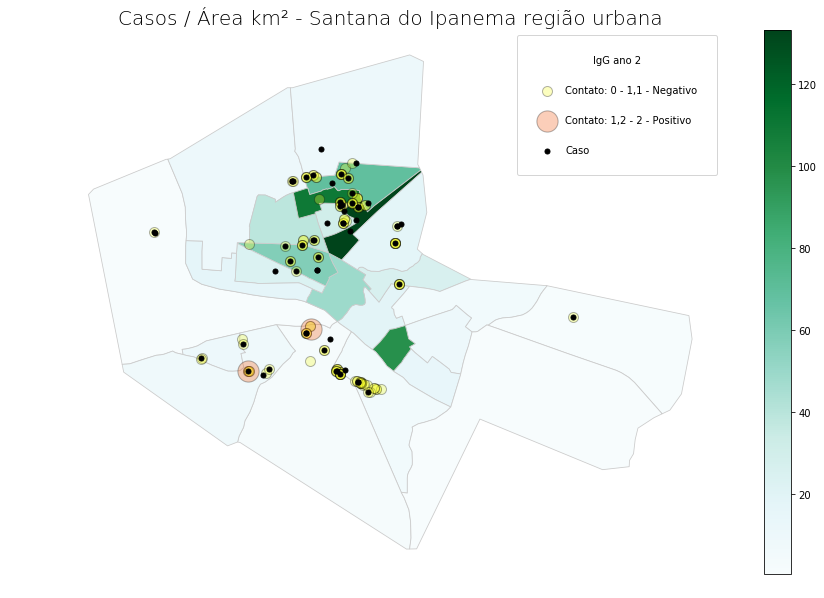

In [50]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano2_igg_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano2_igg_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igg_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igg_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano2_igg_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgG ano 2', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgG Ano 2.png', dpi=300)

In [51]:
amostra = '5.3 SORO IgA'
ano2_iga = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano2_iga.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano2_iga_casos = ano2_iga[ano2_iga['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano2_iga_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano2_iga_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano2_iga_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano2_iga_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


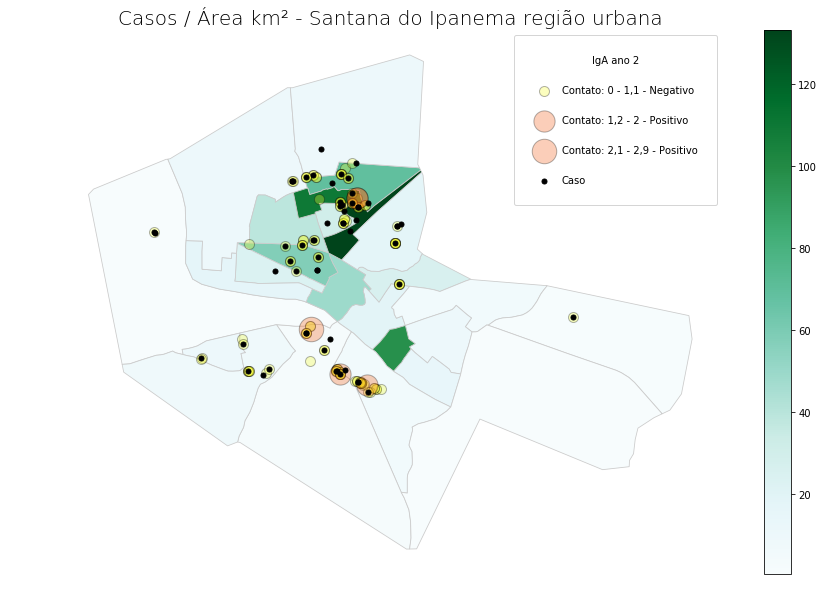

In [52]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano2_iga_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano2_iga_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_iga_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_iga_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano2_iga_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgA ano 2', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA Ano 2.png', dpi=300)

In [53]:
amostra = '6.1 SORO IgM'
ano3_igm = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano3_igm.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano3_igm_casos = ano3_igm[ano3_igm['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano3_igm_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano3_igm_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano3_igm_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano3_igm_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

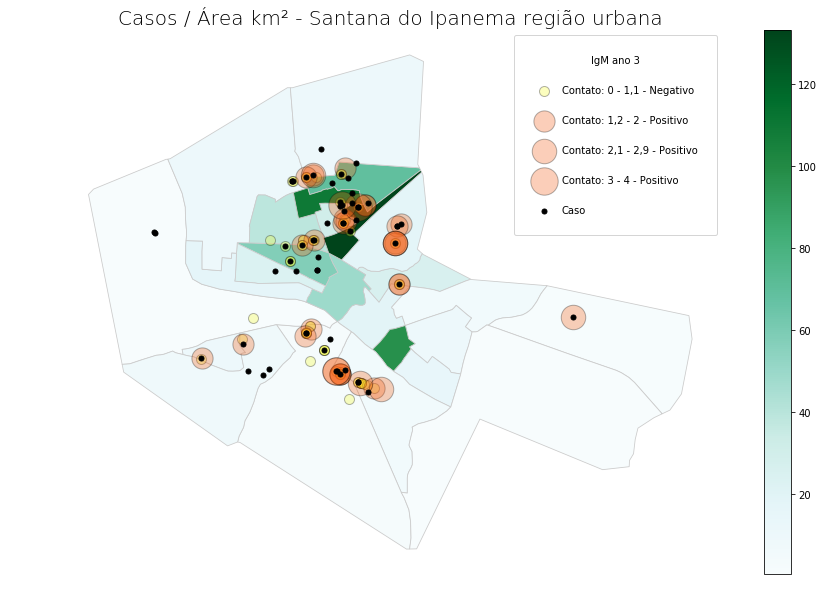

In [54]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano3_igm_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano3_igm_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igm_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igm_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano3_igm_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM ano 3', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM Ano 3.png', dpi=300)

In [55]:
amostra = '6.2 SORO IgG'
ano3_igg = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano3_igg.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano3_igg_casos = ano3_igg[ano3_igg['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano3_igg_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano3_igg_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano3_igg_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano3_igg_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


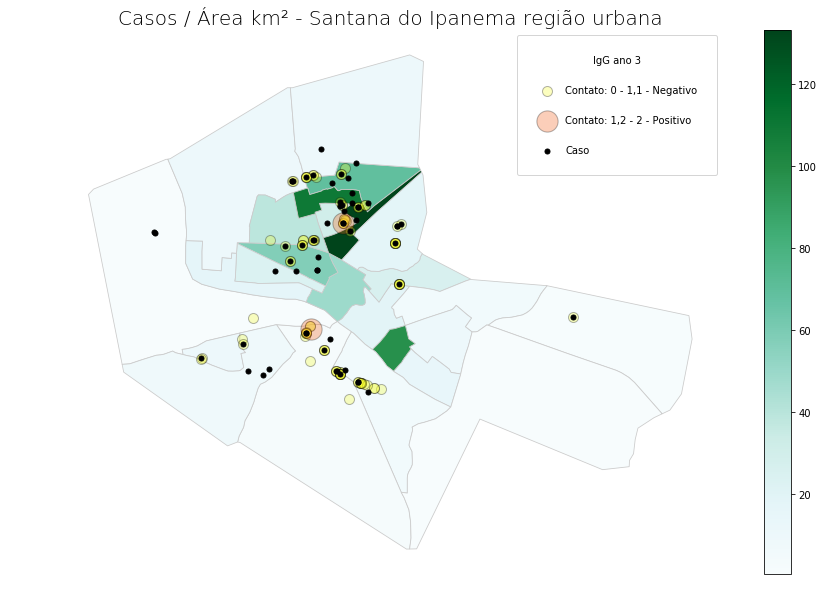

In [56]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano3_igg_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano3_igg_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igg_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igg_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano3_igg_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgG ano 3', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgG Ano 3.png', dpi=300)

In [57]:
amostra = '6.3 SORO IgA'
ano3_iga = contatos_geodf[['POPULAÇÃO ESTUDADA', amostra, 'geometry']]
coletados = ano3_iga.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano3_iga_casos = ano3_iga[ano3_iga['POPULAÇÃO ESTUDADA'] == '1-CASO']

ano3_iga_ate_cutoff_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO') 
    & (coletados[amostra] < 1.2)
]

ano3_iga_acima12_abaixo21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2.1)
]

ano3_iga_acima21_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 2.1) 
    & (coletados[amostra] < 3)
]

ano3_iga_acima3_contatos = coletados[
    (coletados['POPULAÇÃO ESTUDADA'] == '2-CONTATO')
    & (coletados[amostra] >= 3)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


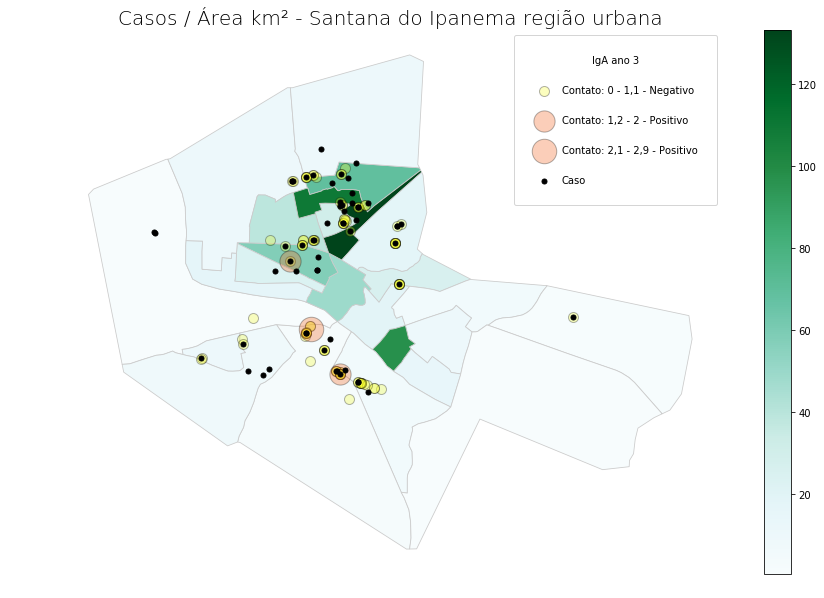

In [58]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano3_iga_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 1,1 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano3_iga_acima12_abaixo21_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 2 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_iga_acima21_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 2,1 - 2,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_iga_acima3_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 3 - 4 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano3_iga_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1)

leg = ax.legend(title='IgA ano 3', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA Ano 3.png', dpi=300)

In [59]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '4.4 SALIVA IgM'
ano1_igm_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano1_igm_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_igm_saliva_casos = ano1_igm_saliva[ano1_igm_saliva[pop] == '1-CASO']

ano1_igm_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano1_igm_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano1_igm_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano1_igm_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


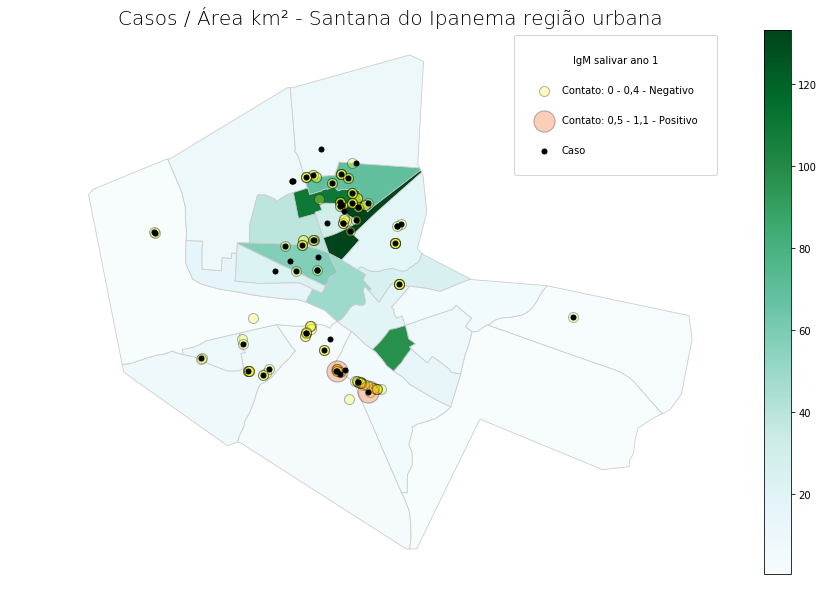

In [60]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_igm_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_igm_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM salivar ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM salivar Ano 1.png', dpi=300)

In [61]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '4.5 SALIVA IgA'
ano1_iga_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano1_iga_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_iga_saliva_casos = ano1_iga_saliva[ano1_iga_saliva[pop] == '1-CASO']

ano1_iga_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano1_iga_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano1_iga_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano1_iga_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


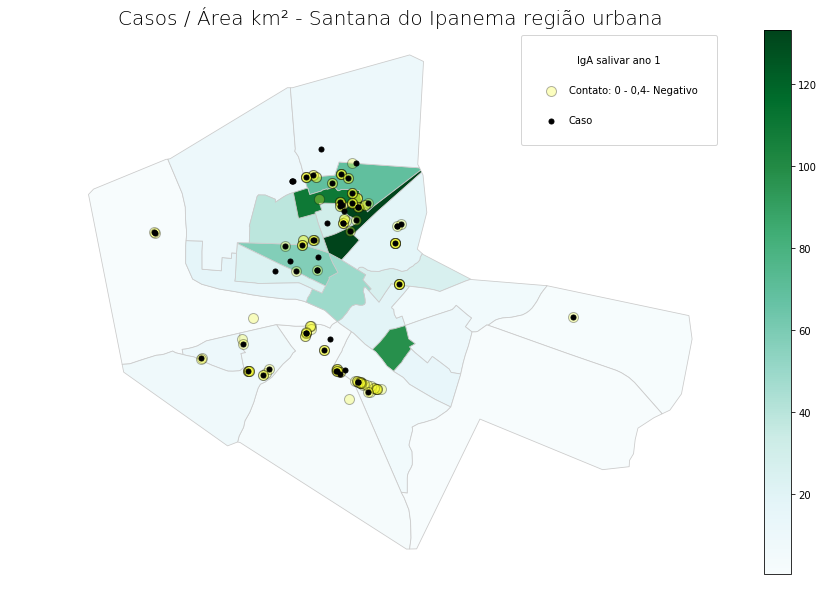

In [62]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_iga_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4- Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_iga_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgA salivar ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA salivar Ano 1.png', dpi=300)

In [63]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '4.6 SALIVA recoleta IgM'
ano1_igm_saliva_rec = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano1_igm_saliva_rec.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_igm_saliva_rec_casos = ano1_igm_saliva_rec[ano1_igm_saliva_rec[pop] == '1-CASO']

ano1_igm_saliva_rec_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano1_igm_saliva_rec_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano1_igm_saliva_rec_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano1_igm_saliva_rec_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

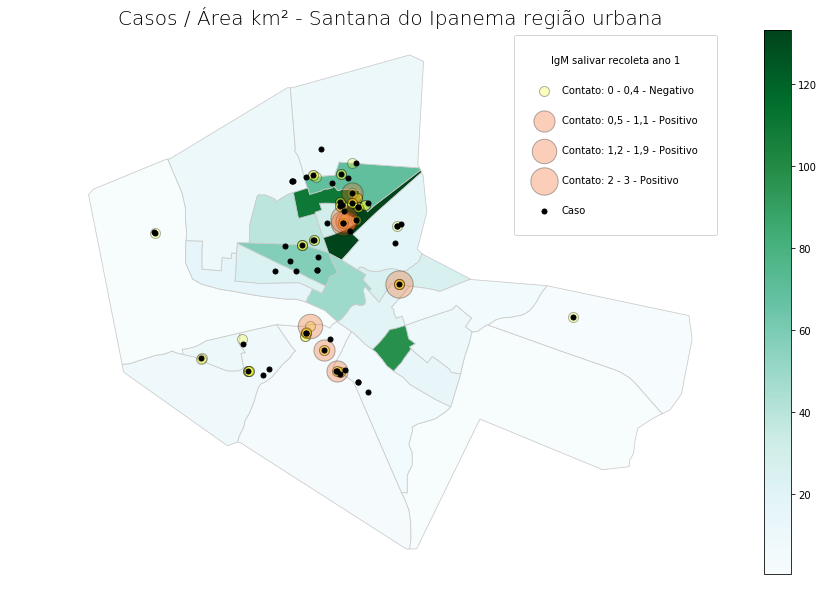

In [64]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_igm_saliva_rec_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_rec_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_rec_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_igm_saliva_rec_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_igm_saliva_rec_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM salivar recoleta ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM salivar recoleta Ano 1.png', dpi=300)

In [65]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '4.7 SALIVA recoleta IgA'
ano1_iga_saliva_rec = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano1_iga_saliva_rec.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano1_iga_saliva_rec_casos = ano1_iga_saliva_rec[ano1_iga_saliva_rec[pop] == '1-CASO']

ano1_iga_saliva_rec_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano1_iga_saliva_rec_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano1_iga_saliva_rec_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano1_iga_saliva_rec_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


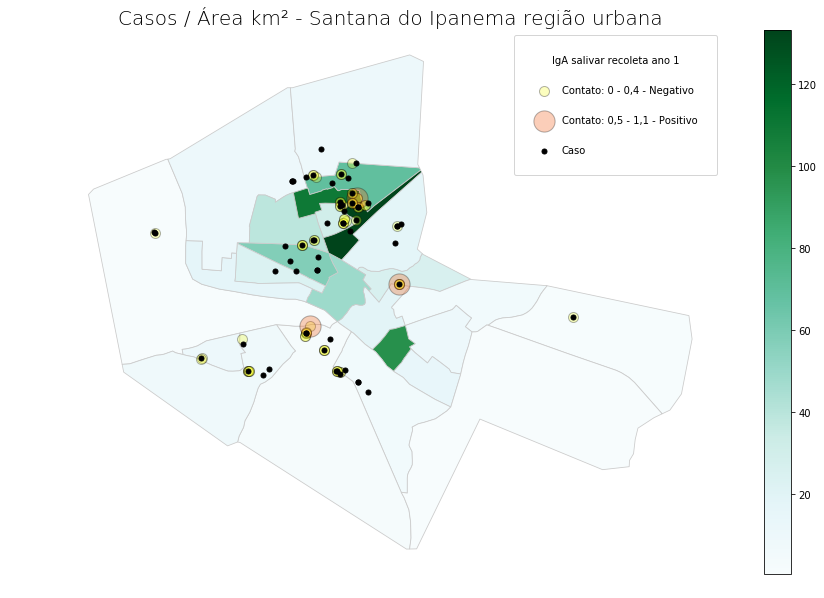

In [66]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano1_iga_saliva_rec_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_rec_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_rec_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano1_iga_saliva_rec_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano1_iga_saliva_rec_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgA salivar recoleta ano 1', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA salivar recoleta Ano 1.png', dpi=300)

In [67]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '5.4 SALIVA IgM'
ano2_igm_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano2_igm_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano2_igm_saliva_casos = ano2_igm_saliva[ano2_igm_saliva[pop] == '1-CASO']

ano2_igm_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano2_igm_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano2_igm_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano2_igm_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

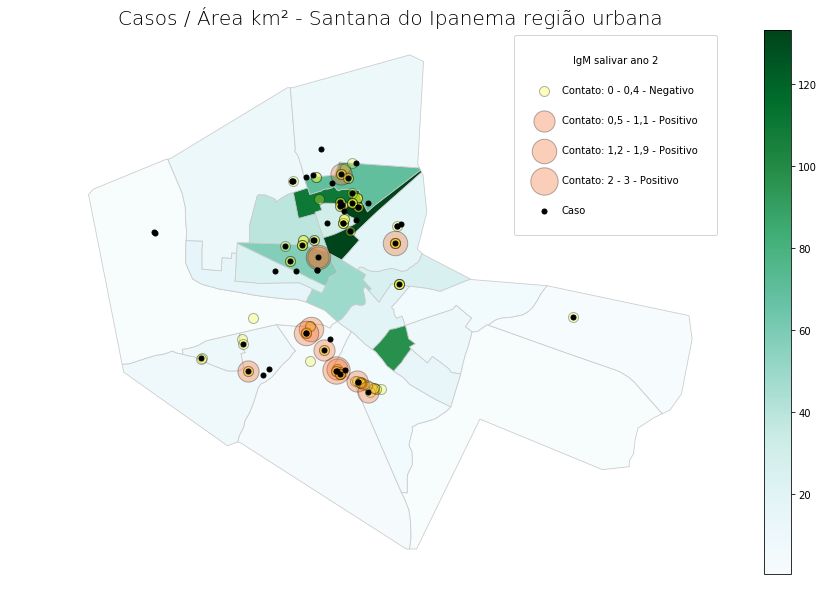

In [68]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano2_igm_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano2_igm_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igm_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_igm_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano2_igm_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM salivar ano 2', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM salivar Ano 2.png', dpi=300)

In [69]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '5.5 SALIVA IgA'
ano2_iga_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano2_iga_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano2_iga_saliva_casos = ano2_iga_saliva[ano2_iga_saliva[pop] == '1-CASO']

ano2_iga_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano2_iga_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano2_iga_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano2_iga_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


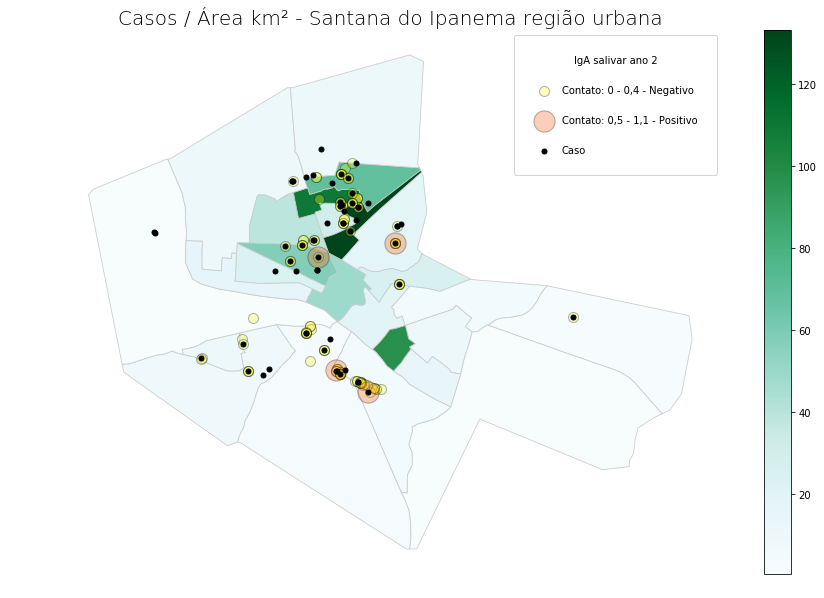

In [70]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano2_iga_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano2_iga_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_iga_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano2_iga_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano2_iga_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgA salivar ano 2', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA salivar Ano 2.png', dpi=300)

In [71]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '6.4 SALIVA IgM'
ano3_igm_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano3_igm_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano3_igm_saliva_casos = ano3_igm_saliva[ano3_igm_saliva[pop] == '1-CASO']

ano3_igm_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano3_igm_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano3_igm_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano3_igm_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

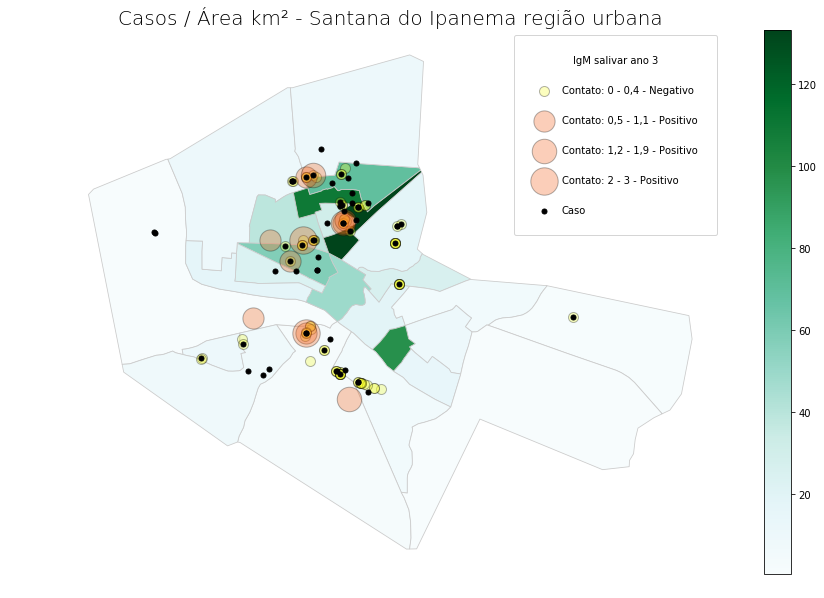

In [72]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano3_igm_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano3_igm_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igm_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_igm_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano3_igm_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgM salivar ano 3', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgM salivar Ano 3.png', dpi=300)

In [73]:
pop = 'POPULAÇÃO ESTUDADA'
amostra = '6.5 SALIVA IgA'
ano3_iga_saliva = contatos_geodf[[pop, amostra, 'geometry']]
coletados = ano3_iga_saliva.dropna(subset=[amostra])
coletados = coletados[coletados[amostra] != 'ÑC']

ano3_iga_saliva_casos = ano3_iga_saliva[ano3_iga_saliva[pop] == '1-CASO']

ano3_iga_saliva_ate_cutoff_contatos = coletados[
    (coletados[pop] == '2-CONTATO') 
    & (coletados[amostra] < 0.5)
]

ano3_iga_saliva_acima05_abaixo12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 0.5) 
    & (coletados[amostra] < 1.2)
]

ano3_iga_saliva_acima12_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 1.2) 
    & (coletados[amostra] < 2)
]

ano3_iga_saliva_acima2_contatos = coletados[
    (coletados[pop] == '2-CONTATO')
    & (coletados[amostra] >= 2)
]

C:\Program Files\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\geopandas\plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


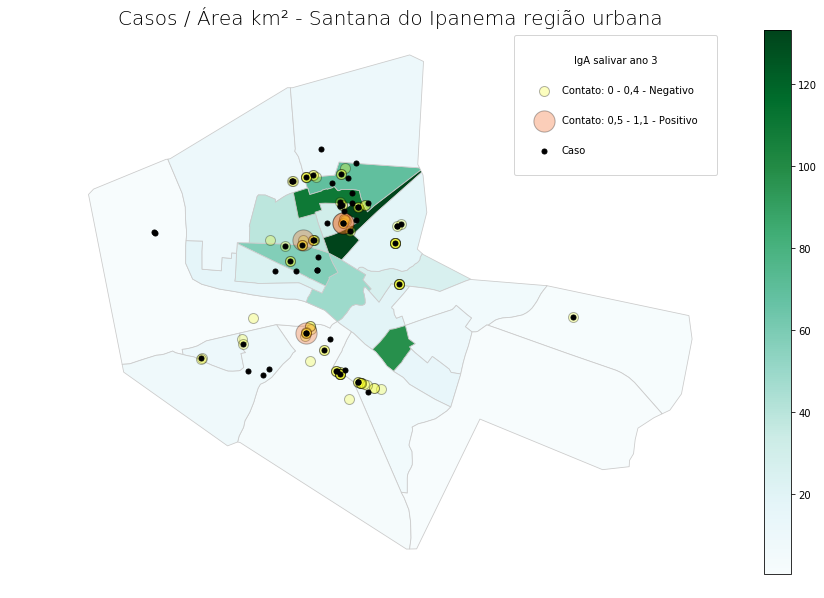

In [74]:
vmin_casos_area, vmax_casos_area = santana_regiao_urbana['Casos/Área km²'].min(), santana_regiao_urbana['Casos/Área km²'].max()
variable_pop = 'Casos/Área km²'
fig, ax = plt.subplots(1, figsize=(15, 10))
santana_regiao_urbana.plot(column=variable_pop, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Casos / Área km² - Santana do Ipanema região urbana', fontdict={'fontsize': '20', 'fontweight':'3'})
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin_casos_area, vmax=vmax_casos_area))
sm._A = []
cbar = fig.colorbar(sm)

ano3_iga_saliva_ate_cutoff_contatos.plot(ax=ax, markersize=100, edgecolor='black', 
                              marker='o', label='Contato: 0 - 0,4 - Negativo', facecolor='#F7FE2E', 
                              linewidth=1, alpha=0.3)

ano3_iga_saliva_acima05_abaixo12_contatos.plot(ax=ax, markersize=450, edgecolor='black', 
                              marker='o', label='Contato: 0,5 - 1,1 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_iga_saliva_acima12_contatos.plot(ax=ax, markersize=600, edgecolor='black', 
                              marker='o', label='Contato: 1,2 - 1,9 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)

ano3_iga_saliva_acima2_contatos.plot(ax=ax, markersize=750, edgecolor='black', 
                              marker='o', label='Contato: 2 - 3 - Positivo', facecolor='#F66218', 
                              linewidth=1, alpha=0.3)
ano3_iga_saliva_casos.plot(ax=ax, markersize=100, color='black', 
                           marker='.', label='Caso', 
                           linewidth=1, alpha=1)

leg = ax.legend(title='IgA salivar ano 3', fontsize=10, labelspacing=2, borderpad=2)
fig.savefig('IgA salivar Ano 3.png', dpi=300)